# Temporal-Difference Learning Lab: SARSA vs Q-Learning
## CliffWalking Environment Analysis

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from collections import defaultdict
import pandas as pd
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
def epsilon_greedy_action(Q: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    """
    Select action using ε-greedy policy.

    Args:
        Q: Q-table of shape (n_states, n_actions)
        state: Current state
        epsilon: Exploration probability
        n_actions: Number of available actions

    Returns:
        Selected action
    """
    if np.random.random() < epsilon:
        # Explore: random action
        return np.random.choice(n_actions)
    else:
        # Exploit: greedy action (break ties randomly)
        max_value = np.max(Q[state])
        max_actions = np.where(Q[state] == max_value)[0]
        return np.random.choice(max_actions)

In [3]:
def sarsa(env: gym.Env,
          num_episodes: int = 500,
          alpha: float = 0.1,
          gamma: float = 0.99,
          epsilon: float = 0.1,
          epsilon_decay: float = 1.0,
          epsilon_min: float = 0.01) -> Tuple[np.ndarray, List[float], List[int]]:
    """
    SARSA: On-policy TD control algorithm.

    Updates Q(S,A) using the action A' actually taken in state S'.
    This makes SARSA learn the value of the ε-greedy policy it follows.

    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to run
        alpha: Learning rate (step size)
        gamma: Discount factor
        epsilon: Initial exploration rate
        epsilon_decay: Decay rate for epsilon per episode
        epsilon_min: Minimum epsilon value

    Returns:
        Q: Learned Q-table
        episode_returns: Sum of rewards per episode
        episode_lengths: Number of steps per episode
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Initialize Q-table with zeros
    Q = np.zeros((n_states, n_actions))

    episode_returns = []
    episode_lengths = []
    current_epsilon = epsilon

    for episode in range(num_episodes):
        # Reset environment and get initial state
        state, _ = env.reset()

        # Choose initial action using ε-greedy policy
        action = epsilon_greedy_action(Q, state, current_epsilon, n_actions)

        total_reward = 0
        steps = 0
        done = False

        while not done:
            # Take action, observe next state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            if not done:
                # Choose next action using ε-greedy policy (ON-POLICY)
                next_action = epsilon_greedy_action(Q, next_state, current_epsilon, n_actions)

                # SARSA update: Use Q(S', A') where A' is from policy
                td_target = reward + gamma * Q[next_state, next_action]
                td_error = td_target - Q[state, action]
                Q[state, action] += alpha * td_error

                # Move to next state and action
                state = next_state
                action = next_action
            else:
                # Terminal state: no next action, V(terminal) = 0
                td_target = reward
                td_error = td_target - Q[state, action]
                Q[state, action] += alpha * td_error

        episode_returns.append(total_reward)
        episode_lengths.append(steps)

        # Decay epsilon
        current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)

    return Q, episode_returns, episode_lengths

In [4]:
def q_learning(env: gym.Env,
               num_episodes: int = 500,
               alpha: float = 0.1,
               gamma: float = 0.99,
               epsilon: float = 0.1,
               epsilon_decay: float = 1.0,
               epsilon_min: float = 0.01) -> Tuple[np.ndarray, List[float], List[int]]:
    """
    Q-Learning: Off-policy TD control algorithm.

    Updates Q(S,A) using max_a Q(S',a) regardless of the action actually taken.
    This makes Q-learning learn the optimal policy while following ε-greedy.

    Args:
        env: Gymnasium environment
        num_episodes: Number of episodes to run
        alpha: Learning rate (step size)
        gamma: Discount factor
        epsilon: Initial exploration rate
        epsilon_decay: Decay rate for epsilon per episode
        epsilon_min: Minimum epsilon value

    Returns:
        Q: Learned Q-table
        episode_returns: Sum of rewards per episode
        episode_lengths: Number of steps per episode
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Initialize Q-table with zeros
    Q = np.zeros((n_states, n_actions))

    episode_returns = []
    episode_lengths = []
    current_epsilon = epsilon

    for episode in range(num_episodes):
        # Reset environment and get initial state
        state, _ = env.reset()

        total_reward = 0
        steps = 0
        done = False

        while not done:
            # Choose action using ε-greedy policy (behavior policy)
            action = epsilon_greedy_action(Q, state, current_epsilon, n_actions)

            # Take action, observe next state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            # Q-Learning update: Use max_a Q(S',a) (target policy: greedy)
            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                # Terminal state: V(terminal) = 0
                td_target = reward

            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            # Move to next state
            state = next_state

        episode_returns.append(total_reward)
        episode_lengths.append(steps)

        # Decay epsilon
        current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)

    return Q, episode_returns, episode_lengths

### Multi-Seed Experiments with Confidence Intervals

In [7]:
def run_multiple_seeds(algorithm_func,
                       env_name: str = "CliffWalking-v1",
                       num_seeds: int = 30,
                       num_episodes: int = 500,
                       **kwargs) -> Dict:
    """
    Run algorithm with multiple random seeds and collect statistics.

    Args:
        algorithm_func: Either sarsa or q_learning function
        env_name: Name of Gymnasium environment
        num_seeds: Number of random seeds to run
        num_episodes: Number of episodes per seed
        **kwargs: Additional arguments for algorithm

    Returns:
        Dictionary with results including mean, std, and confidence intervals
    """
    all_returns = []
    all_lengths = []
    all_Q_tables = []

    for seed in range(num_seeds):
        # Create environment with specific seed
        env = gym.make(env_name)
        env.reset(seed=seed)
        np.random.seed(seed)

        # Run algorithm
        Q, episode_returns, episode_lengths = algorithm_func(
            env, num_episodes=num_episodes, **kwargs
        )

        all_returns.append(episode_returns)
        all_lengths.append(episode_lengths)
        all_Q_tables.append(Q)

        env.close()

        if (seed + 1) % 10 == 0:
            print(f"  Completed {seed + 1}/{num_seeds} seeds")

    # Convert to numpy arrays for easier computation
    all_returns = np.array(all_returns)  # Shape: (num_seeds, num_episodes)
    all_lengths = np.array(all_lengths)

    # Compute statistics
    mean_returns = np.mean(all_returns, axis=0)
    std_returns = np.std(all_returns, axis=0)

    # 95% confidence interval using t-distribution
    confidence_level = 0.95
    degrees_freedom = num_seeds - 1
    t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)
    margin_error = t_value * (std_returns / np.sqrt(num_seeds))

    ci_lower = mean_returns - margin_error
    ci_upper = mean_returns + margin_error

    return {
        'all_returns': all_returns,
        'all_lengths': all_lengths,
        'all_Q_tables': all_Q_tables,
        'mean_returns': mean_returns,
        'std_returns': std_returns,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'final_mean': np.mean(all_returns[:, -100:]),  # Last 100 episodes
        'final_std': np.std(all_returns[:, -100:])
    }

In [8]:
print("Running SARSA with 30 seeds...")
sarsa_results = run_multiple_seeds(
    sarsa,
    num_seeds=30,
    num_episodes=500,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    epsilon_decay=1.0
)

Running SARSA with 30 seeds...
  Completed 10/30 seeds
  Completed 20/30 seeds
  Completed 30/30 seeds


In [9]:
print("\nRunning Q-Learning with 30 seeds...")
qlearning_results = run_multiple_seeds(
    q_learning,
    num_seeds=30,
    num_episodes=500,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    epsilon_decay=1.0
)


Running Q-Learning with 30 seeds...
  Completed 10/30 seeds
  Completed 20/30 seeds
  Completed 30/30 seeds


### Learning Curves with Confidence Intervals

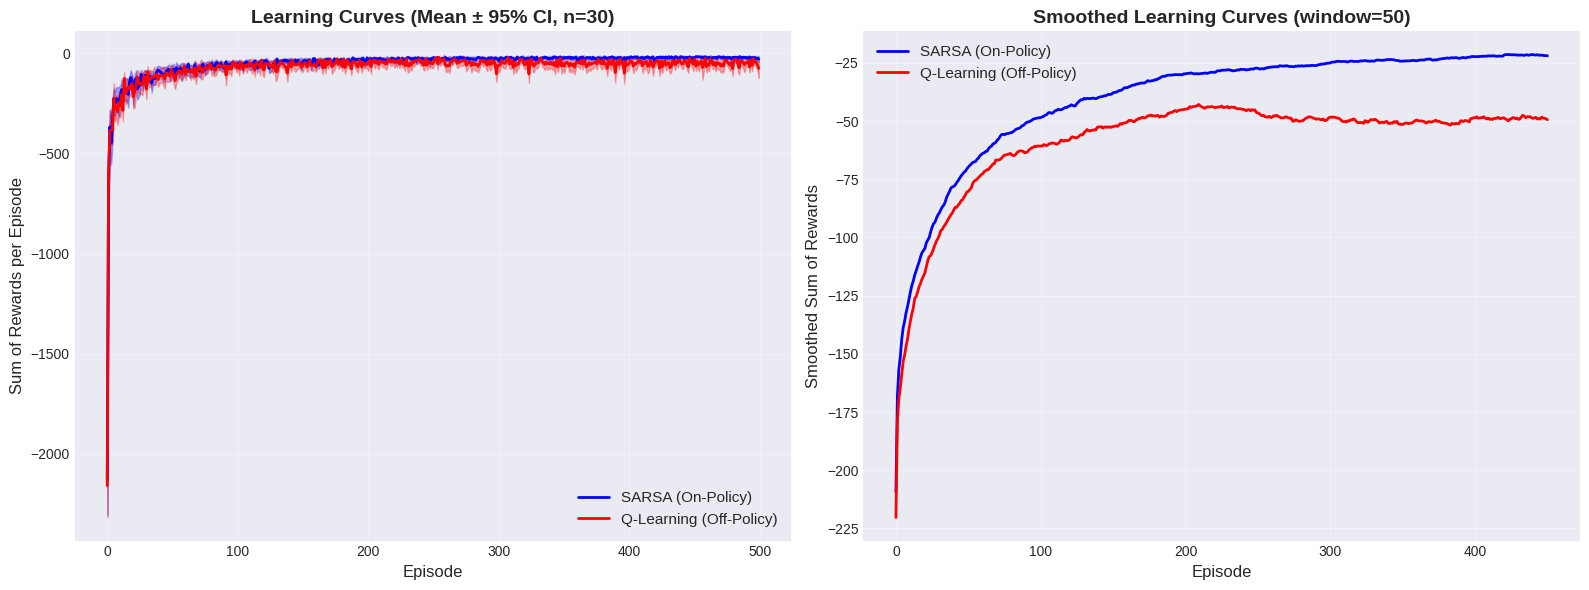

In [10]:
def plot_learning_curves_with_ci(sarsa_results: Dict, qlearning_results: Dict):
    """
    Plot learning curves with 95% confidence intervals.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    episodes = np.arange(len(sarsa_results['mean_returns']))

    # Plot 1: Raw learning curves with confidence intervals
    ax = axes[0]

    # SARSA
    ax.plot(episodes, sarsa_results['mean_returns'],
            label='SARSA (On-Policy)', linewidth=2, color='blue')
    ax.fill_between(episodes,
                     sarsa_results['ci_lower'],
                     sarsa_results['ci_upper'],
                     alpha=0.3, color='blue')

    # Q-Learning
    ax.plot(episodes, qlearning_results['mean_returns'],
            label='Q-Learning (Off-Policy)', linewidth=2, color='red')
    ax.fill_between(episodes,
                     qlearning_results['ci_lower'],
                     qlearning_results['ci_upper'],
                     alpha=0.3, color='red')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Sum of Rewards per Episode', fontsize=12)
    ax.set_title('Learning Curves (Mean ± 95% CI, n=30)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 2: Smoothed curves (moving average)
    ax = axes[1]
    window = 50

    sarsa_smooth = np.convolve(sarsa_results['mean_returns'],
                               np.ones(window)/window, mode='valid')
    qlearning_smooth = np.convolve(qlearning_results['mean_returns'],
                                   np.ones(window)/window, mode='valid')

    episodes_smooth = np.arange(len(sarsa_smooth))

    ax.plot(episodes_smooth, sarsa_smooth,
            label='SARSA (On-Policy)', linewidth=2, color='blue')
    ax.plot(episodes_smooth, qlearning_smooth,
            label='Q-Learning (Off-Policy)', linewidth=2, color='red')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Smoothed Sum of Rewards', fontsize=12)
    ax.set_title(f'Smoothed Learning Curves (window={window})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_learning_curves_with_ci(sarsa_results, qlearning_results)

### Value Function Visualization

In [11]:
def visualize_value_function(Q: np.ndarray, title: str = "Value Function"):
    """
    Visualize the learned value function as a heatmap.

    Args:
        Q: Q-table of shape (n_states, n_actions)
        title: Title for the plot
    """
    # Compute state values as max over actions
    V = np.max(Q, axis=1)

    # Reshape to grid (4x12 for CliffWalking)
    V_grid = V.reshape(4, 12)

    fig, ax = plt.subplots(figsize=(14, 5))

    # Create heatmap
    im = ax.imshow(V_grid, cmap='RdYlGn', interpolation='nearest', aspect='auto')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='State Value V(s) = max_a Q(s,a)')

    # Add grid
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(np.arange(12))
    ax.set_yticklabels(np.arange(4))
    ax.grid(True, which='both', color='black', linewidth=0.5)

    # Annotate cells with values
    for i in range(4):
        for j in range(12):
            text = ax.text(j, i, f'{V_grid[i, j]:.1f}',
                          ha="center", va="center", color="black", fontsize=8)

    # Mark special states
    ax.text(0, 3, 'S', ha='center', va='center',
            color='white', fontsize=16, fontweight='bold')
    ax.text(11, 3, 'G', ha='center', va='center',
            color='white', fontsize=16, fontweight='bold')

    # Mark cliff
    for j in range(1, 11):
        ax.add_patch(plt.Rectangle((j-0.4, 3-0.4), 0.8, 0.8,
                                   fill=False, edgecolor='red', linewidth=3))

    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig

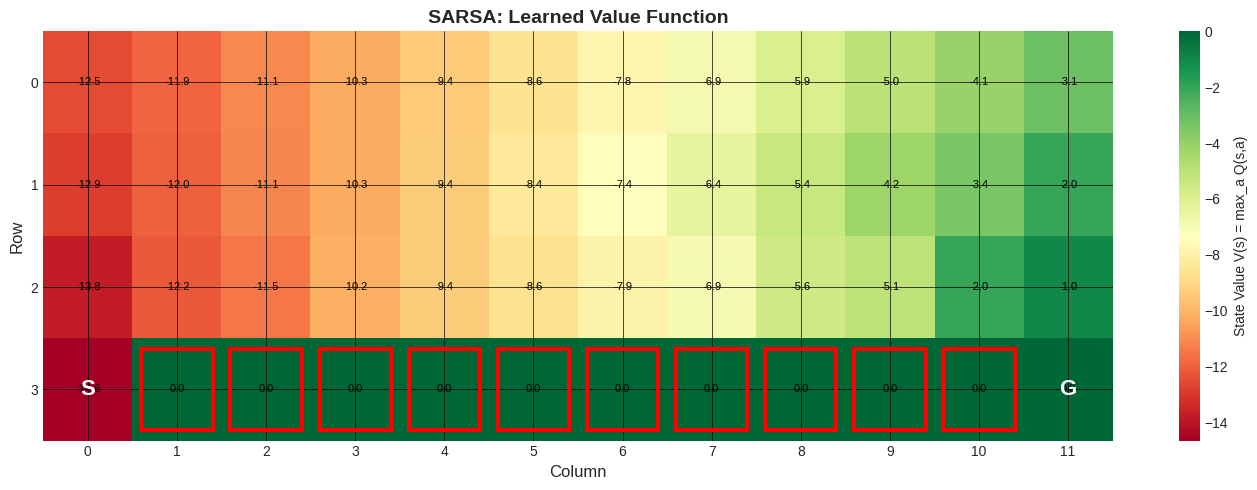

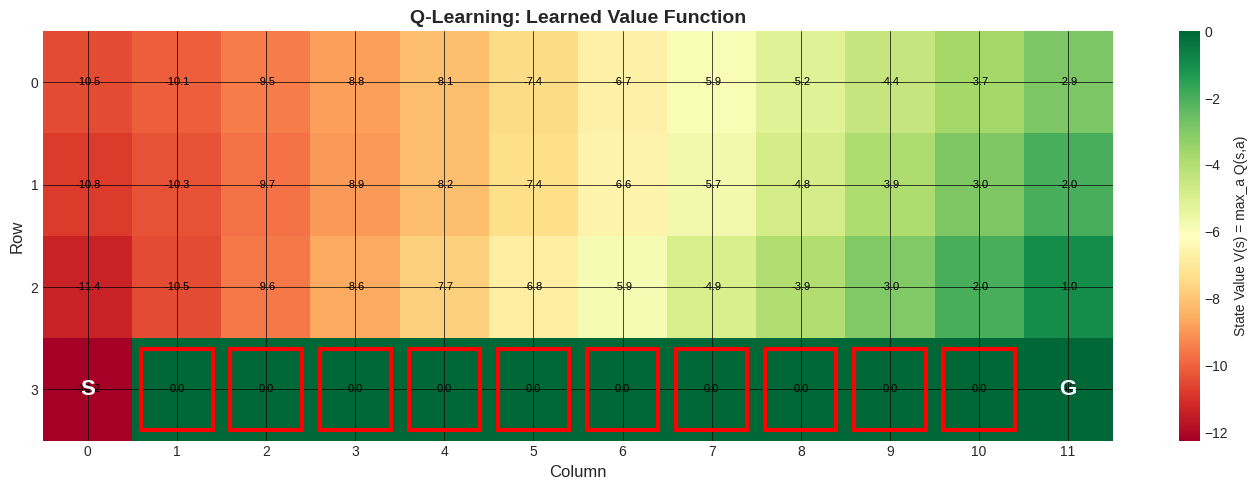

In [12]:
sarsa_Q = sarsa_results['all_Q_tables'][0]
qlearning_Q = qlearning_results['all_Q_tables'][0]

fig1 = visualize_value_function(sarsa_Q, "SARSA: Learned Value Function")
plt.savefig('sarsa_value_function.png', dpi=300, bbox_inches='tight')
plt.show()

fig2 = visualize_value_function(qlearning_Q, "Q-Learning: Learned Value Function")
plt.savefig('qlearning_value_function.png', dpi=300, bbox_inches='tight')
plt.show()

### Policy Visualization with Arrows

/tmp/ipython-input-1348124766.py:74: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


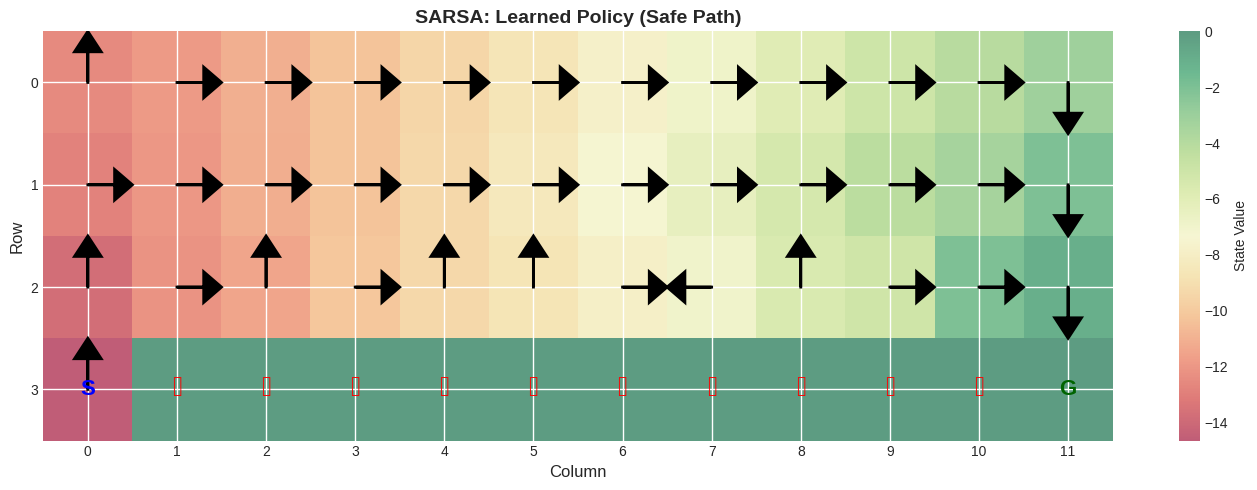

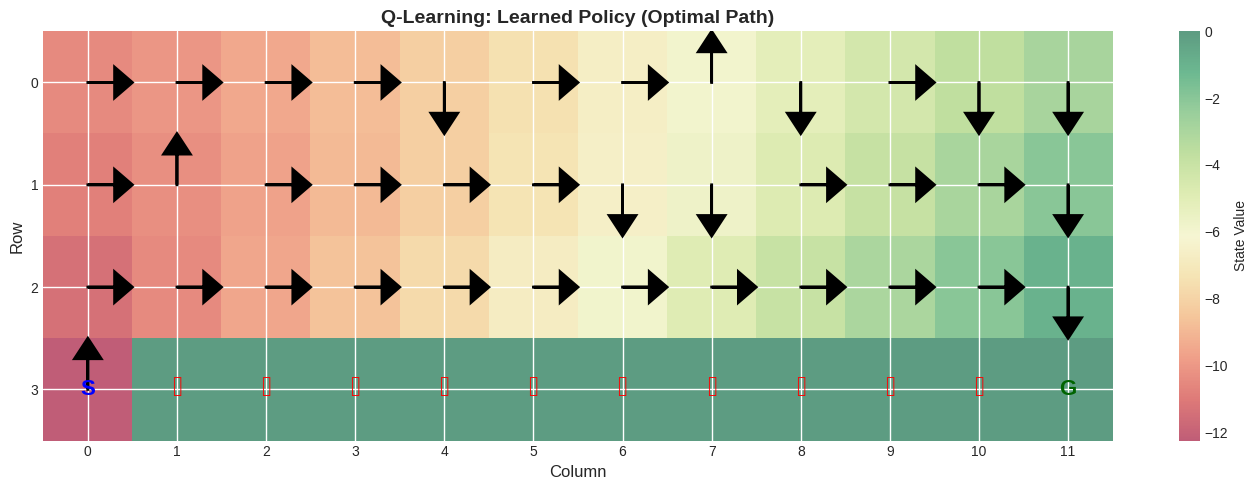

In [13]:
def visualize_policy_arrows(Q: np.ndarray, title: str = "Learned Policy"):
    """
    Visualize the learned policy as arrows on the grid.

    Args:
        Q: Q-table of shape (n_states, n_actions)
        title: Title for the plot
    """
    # Action mapping: 0=Up, 1=Right, 2=Down, 3=Left
    action_arrows = {
        0: '↑',
        1: '→',
        2: '↓',
        3: '←'
    }

    action_deltas = {
        0: (0, -0.3),    # Up
        1: (0.3, 0),     # Right
        2: (0, 0.3),     # Down
        3: (-0.3, 0)     # Left
    }

    # Compute state values for background
    V = np.max(Q, axis=1).reshape(4, 12)

    fig, ax = plt.subplots(figsize=(14, 5))

    # Create heatmap background
    im = ax.imshow(V, cmap='RdYlGn', interpolation='nearest', aspect='auto', alpha=0.6)
    plt.colorbar(im, ax=ax, label='State Value')

    # Add policy arrows
    for state in range(Q.shape[0]):
        row = state // 12
        col = state % 12

        # Get best action (greedy policy)
        best_action = np.argmax(Q[state])

        # Skip cliff states (37-46)
        if 37 <= state <= 46 and state != 36:
            ax.text(col, row, '✗', ha='center', va='center',
                   color='red', fontsize=20, fontweight='bold')
            continue

        # Skip terminal state (47)
        if state == 47:
            ax.text(col, row, 'G', ha='center', va='center',
                   color='darkgreen', fontsize=16, fontweight='bold')
            continue

        # Skip start state marker
        if state == 36:
            ax.text(col, row, 'S', ha='center', va='center',
                   color='blue', fontsize=16, fontweight='bold')

        # Draw arrow for best action
        arrow = action_arrows[best_action]
        dx, dy = action_deltas[best_action]

        ax.arrow(col, row, dx, dy, head_width=0.3, head_length=0.2,
                fc='black', ec='black', linewidth=2)

    # Add grid
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(4))
    ax.grid(True, which='both', color='white', linewidth=1)

    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig


# Visualize policies
fig1 = visualize_policy_arrows(sarsa_Q, "SARSA: Learned Policy (Safe Path)")
plt.show()

fig2 = visualize_policy_arrows(qlearning_Q, "Q-Learning: Learned Policy (Optimal Path)")
plt.show()

### Sample Trajectories

In [14]:
def generate_trajectory(Q: np.ndarray, env: gym.Env, max_steps: int = 100) -> List[int]:
    """
    Generate a trajectory following the greedy policy from Q.

    Args:
        Q: Q-table
        env: Gymnasium environment
        max_steps: Maximum number of steps

    Returns:
        List of states visited
    """
    state, _ = env.reset()
    trajectory = [state]

    for _ in range(max_steps):
        # Greedy action
        action = np.argmax(Q[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        trajectory.append(next_state)

        if terminated or truncated:
            break

        state = next_state

    return trajectory

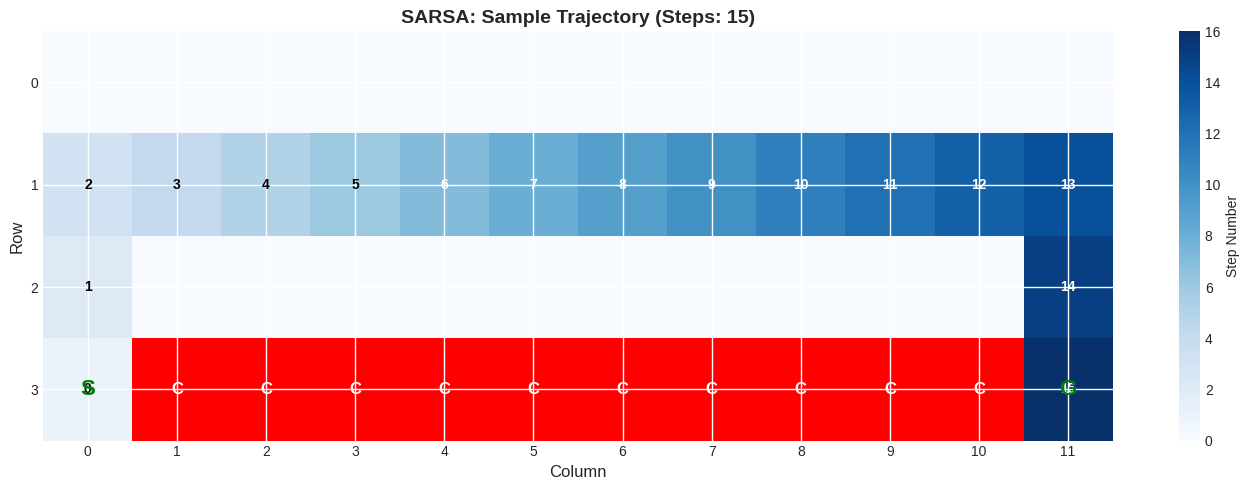

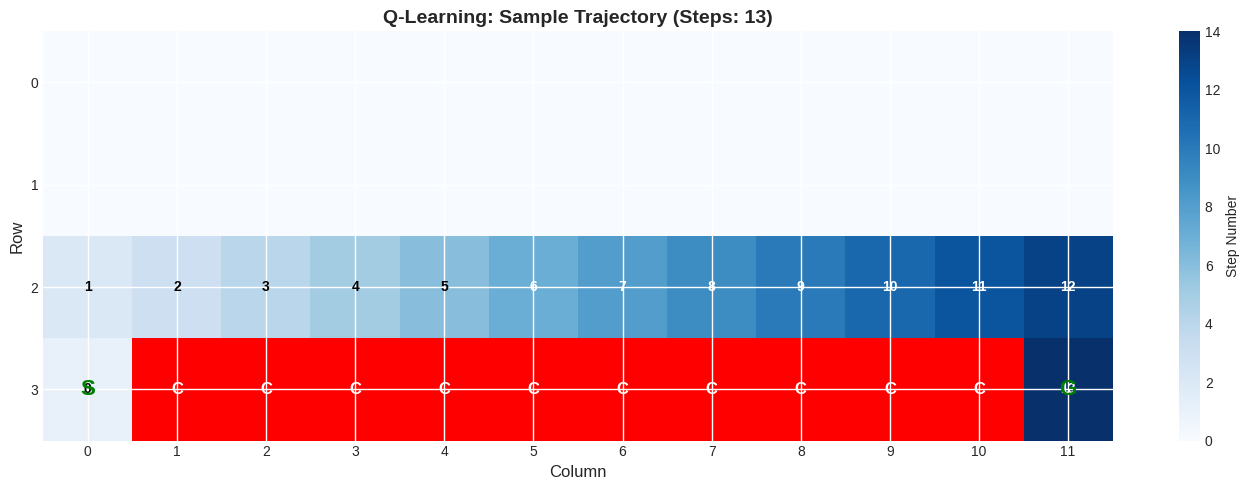

SARSA trajectory length: 15 steps
Q-Learning trajectory length: 13 steps


In [15]:
def visualize_trajectory(trajectory: List[int], title: str = "Sample Trajectory"):
    """
    Visualize a trajectory on the grid.
    """
    fig, ax = plt.subplots(figsize=(14, 5))

    # Create empty grid
    grid = np.zeros((4, 12))

    # Mark cliff
    for j in range(1, 11):
        grid[3, j] = -1

    # Mark trajectory
    for i, state in enumerate(trajectory):
        row = state // 12
        col = state % 12
        grid[row, col] = i + 1

    # Plot
    cmap = plt.cm.Blues
    cmap.set_under('red')
    im = ax.imshow(grid, cmap=cmap, vmin=0, interpolation='nearest', aspect='auto')
    plt.colorbar(im, ax=ax, label='Step Number')

    # Add annotations
    for state in trajectory:
        row = state // 12
        col = state % 12
        step = trajectory.index(state)
        if grid[row, col] != -1:
            ax.text(col, row, str(step), ha='center', va='center',
                   color='white' if step > 5 else 'black', fontsize=10, fontweight='bold')

    # Mark cliff
    for j in range(1, 11):
        ax.text(j, 3, 'C', ha='center', va='center',
               color='white', fontsize=12, fontweight='bold')

    # Mark start and goal
    ax.text(0, 3, 'S', ha='center', va='center',
           color='green', fontsize=16, fontweight='bold')
    ax.text(11, 3, 'G', ha='center', va='center',
           color='green', fontsize=16, fontweight='bold')

    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(4))
    ax.grid(True, which='both', color='white', linewidth=1)
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title(f"{title} (Steps: {len(trajectory)-1})", fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig


# Generate and visualize sample trajectories
env = gym.make("CliffWalking-v1")

sarsa_traj = generate_trajectory(sarsa_Q, env)
fig1 = visualize_trajectory(sarsa_traj, "SARSA: Sample Trajectory")
plt.show()

qlearning_traj = generate_trajectory(qlearning_Q, env)
fig2 = visualize_trajectory(qlearning_traj, "Q-Learning: Sample Trajectory")
plt.show()

env.close()

print(f"SARSA trajectory length: {len(sarsa_traj)-1} steps")
print(f"Q-Learning trajectory length: {len(qlearning_traj)-1} steps")

### Hyperparameter Experiments

HYPERPARAMETER EXPERIMENTS
Testing alpha=0.01...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing alpha=0.05...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing alpha=0.1...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing alpha=0.3...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing alpha=0.5...
  Completed 10/10 seeds
  Completed 10/10 seeds


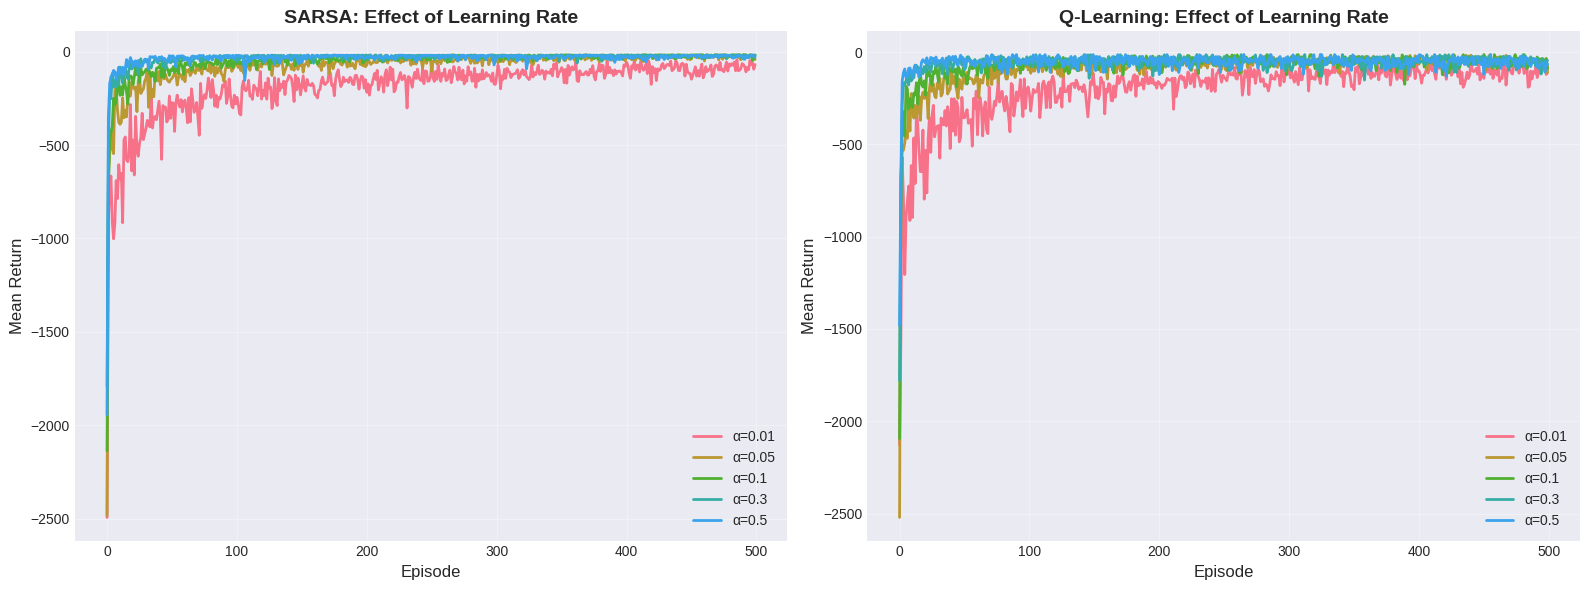


Testing Fixed ε=0.1...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing Decay 0.99...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing Decay 0.995...
  Completed 10/10 seeds
  Completed 10/10 seeds
Testing Fast Decay 0.95...
  Completed 10/10 seeds
  Completed 10/10 seeds


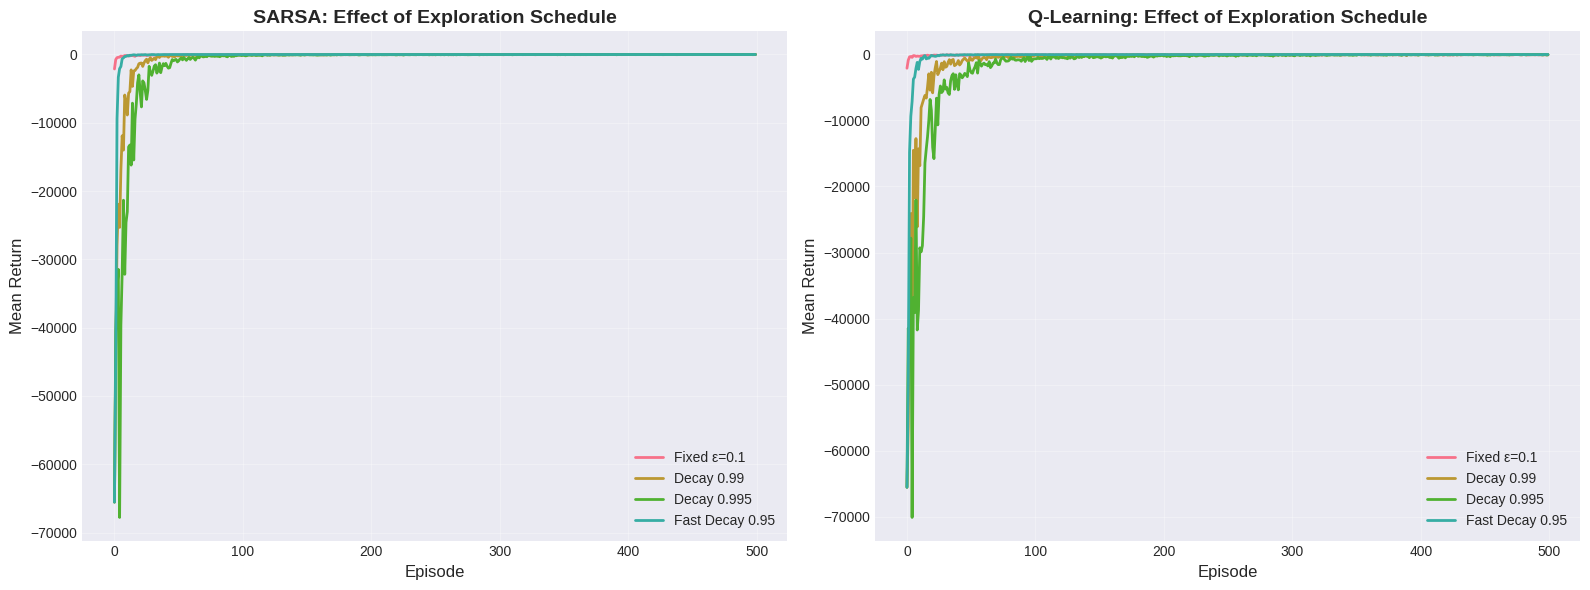

In [16]:
def experiment_learning_rates():
    """
    Experiment with different learning rates (alpha).
    """
    alphas = [0.01, 0.05, 0.1, 0.3, 0.5]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for alpha in alphas:
        print(f"Testing alpha={alpha}...")

        # SARSA
        sarsa_res = run_multiple_seeds(
            sarsa, num_seeds=10, num_episodes=500,
            alpha=alpha, gamma=0.99, epsilon=0.1
        )

        # Q-Learning
        qlearning_res = run_multiple_seeds(
            q_learning, num_seeds=10, num_episodes=500,
            alpha=alpha, gamma=0.99, epsilon=0.1
        )

        # Plot
        episodes = np.arange(len(sarsa_res['mean_returns']))
        axes[0].plot(episodes, sarsa_res['mean_returns'],
                    label=f'α={alpha}', linewidth=2)
        axes[1].plot(episodes, qlearning_res['mean_returns'],
                    label=f'α={alpha}', linewidth=2)

    axes[0].set_xlabel('Episode', fontsize=12)
    axes[0].set_ylabel('Mean Return', fontsize=12)
    axes[0].set_title('SARSA: Effect of Learning Rate', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Episode', fontsize=12)
    axes[1].set_ylabel('Mean Return', fontsize=12)
    axes[1].set_title('Q-Learning: Effect of Learning Rate', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



def experiment_epsilon_schedules():
    """
    Experiment with different epsilon decay schedules.
    """
    schedules = [
        ('Fixed ε=0.1', {'epsilon': 0.1, 'epsilon_decay': 1.0}),
        ('Decay 0.99', {'epsilon': 1.0, 'epsilon_decay': 0.99, 'epsilon_min': 0.01}),
        ('Decay 0.995', {'epsilon': 1.0, 'epsilon_decay': 0.995, 'epsilon_min': 0.01}),
        ('Fast Decay 0.95', {'epsilon': 1.0, 'epsilon_decay': 0.95, 'epsilon_min': 0.01}),
    ]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for name, params in schedules:
        print(f"Testing {name}...")

        # SARSA
        sarsa_res = run_multiple_seeds(
            sarsa, num_seeds=10, num_episodes=500,
            alpha=0.1, gamma=0.99, **params
        )

        # Q-Learning
        qlearning_res = run_multiple_seeds(
            q_learning, num_seeds=10, num_episodes=500,
            alpha=0.1, gamma=0.99, **params
        )

        # Plot
        episodes = np.arange(len(sarsa_res['mean_returns']))
        axes[0].plot(episodes, sarsa_res['mean_returns'],
                    label=name, linewidth=2)
        axes[1].plot(episodes, qlearning_res['mean_returns'],
                    label=name, linewidth=2)

    axes[0].set_xlabel('Episode', fontsize=12)
    axes[0].set_ylabel('Mean Return', fontsize=12)
    axes[0].set_title('SARSA: Effect of Exploration Schedule', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Episode', fontsize=12)
    axes[1].set_ylabel('Mean Return', fontsize=12)
    axes[1].set_title('Q-Learning: Effect of Exploration Schedule',
                     fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



# Run hyperparameter experiments
print("HYPERPARAMETER EXPERIMENTS")

experiment_learning_rates()
print()
experiment_epsilon_schedules()

In [17]:
def create_performance_table(sarsa_results: Dict, qlearning_results: Dict):
    """
    Create comprehensive performance comparison table.
    """
    # Compute metrics
    metrics = {
        'Algorithm': ['SARSA (On-Policy)', 'Q-Learning (Off-Policy)'],
        'Final Mean Return': [
            f"{sarsa_results['final_mean']:.2f} ± {sarsa_results['final_std']:.2f}",
            f"{qlearning_results['final_mean']:.2f} ± {qlearning_results['final_std']:.2f}"
        ],
        'Best Episode Return': [
            f"{np.max(sarsa_results['mean_returns']):.2f}",
            f"{np.max(qlearning_results['mean_returns']):.2f}"
        ],
        'Episodes to -15': [
            np.argmax(sarsa_results['mean_returns'] > -15) if np.any(sarsa_results['mean_returns'] > -15) else 'N/A',
            np.argmax(qlearning_results['mean_returns'] > -15) if np.any(qlearning_results['mean_returns'] > -15) else 'N/A'
        ],
        'Avg Episode Length': [
            f"{np.mean(sarsa_results['all_lengths'][:, -100:]):.1f}",
            f"{np.mean(qlearning_results['all_lengths'][:, -100:]):.1f}"
        ],
        'Learning Stability (Std)': [
            f"{np.mean(sarsa_results['std_returns'][-100:]):.2f}",
            f"{np.mean(qlearning_results['std_returns'][-100:]):.2f}"
        ]
    }

    df = pd.DataFrame(metrics)

    print("PERFORMANCE COMPARISON TABLE")
    print(df.to_string(index=False))

    # Additional analysis
    print("\nKEY INSIGHTS:")

    sarsa_final = sarsa_results['final_mean']
    qlearning_final = qlearning_results['final_mean']

    if qlearning_final > sarsa_final:
        diff = qlearning_final - sarsa_final
        print(f"Q-Learning achieves {diff:.2f} higher final return than SARSA")
    else:
        diff = sarsa_final - qlearning_final
        print(f"SARSA achieves {diff:.2f} higher final return than Q-Learning")

    sarsa_stability = np.mean(sarsa_results['std_returns'][-100:])
    qlearning_stability = np.mean(qlearning_results['std_returns'][-100:])

    if sarsa_stability < qlearning_stability:
        print(f"SARSA shows more stable learning (std: {sarsa_stability:.2f} vs {qlearning_stability:.2f})")

    return df

performance_df = create_performance_table(sarsa_results, qlearning_results)

PERFORMANCE COMPARISON TABLE
              Algorithm Final Mean Return Best Episode Return Episodes to -15 Avg Episode Length Learning Stability (Std)
      SARSA (On-Policy)    -22.13 ± 22.28              -16.93             N/A               17.9                    18.51
Q-Learning (Off-Policy)    -48.99 ± 71.74              -20.87             N/A               17.1                    67.35

KEY INSIGHTS:
SARSA achieves 26.86 higher final return than Q-Learning
SARSA shows more stable learning (std: 18.51 vs 67.35)


### Behavioral Analysis: Safe vs Optimal Paths


In [19]:
def analyze_path_preferences(sarsa_Q: np.ndarray, qlearning_Q: np.ndarray):
    """
    Analyze which paths SARSA and Q-Learning prefer.
    """
    print("\n" + "="*80)
    print("PATH PREFERENCE ANALYSIS")
    print("="*80)

    # Analyze state 36 (start state) - which direction do they go?
    start_state = 36

    action_names = ['Up', 'Right', 'Down', 'Left']

    print("\nFrom START state (36):")
    print("-" * 40)
    print("SARSA Q-values:")
    for i, action in enumerate(action_names):
        print(f"  {action:8s}: {sarsa_Q[start_state, i]:8.3f}", end="")
        if i == np.argmax(sarsa_Q[start_state]):
            print(" ← BEST")
        else:
            print()

    print("\nQ-Learning Q-values:")
    for i, action in enumerate(action_names):
        print(f"  {action:8s}: {qlearning_Q[start_state, i]:8.3f}", end="")
        if i == np.argmax(qlearning_Q[start_state]):
            print(" ← BEST")
        else:
            print()

    # Analyze states near the cliff
    print("\n" + "-"*80)
    print("CLIFF-ADJACENT STATES (row 2, above cliff):")
    print("-" * 40)

    cliff_adjacent = [24 + i for i in range(1, 11)]  # States 25-34

    sarsa_goes_down = sum([np.argmax(sarsa_Q[s]) == 2 for s in cliff_adjacent])
    qlearning_goes_down = sum([np.argmax(qlearning_Q[s]) == 2 for s in cliff_adjacent])

    print(f"SARSA:       {sarsa_goes_down}/10 states prefer going DOWN (toward cliff)")
    print(f"Q-Learning:  {qlearning_goes_down}/10 states prefer going DOWN (toward cliff)")

    print("\n" + "-"*80)
    print("INTERPRETATION:")
    print("-" * 40)

    if sarsa_goes_down < qlearning_goes_down:
        print("✓ SARSA is MORE CAUTIOUS - prefers staying away from cliff")
        print("  Reason: SARSA learns value of ε-greedy policy")
        print("  Since ε-exploration might cause cliff fall, SARSA values near-cliff states lower")
        print()
        print("✓ Q-Learning is MORE AGGRESSIVE - willing to go near cliff")
        print("  Reason: Q-Learning learns optimal policy (ignoring exploration)")
        print("  It knows the optimal action is safe, so cliff-adjacent states have high value")

    # Sample path analysis
    print("\n" + "-"*80)
    print("TYPICAL PATHS:")
    print("-" * 40)

    env = gym.make("CliffWalking-v1")

    # SARSA path
    sarsa_traj = generate_trajectory(sarsa_Q, env)
    sarsa_rows = [s // 12 for s in sarsa_traj]
    sarsa_min_row = min(sarsa_rows)

    # Q-Learning path
    qlearning_traj = generate_trajectory(qlearning_Q, env)
    qlearning_rows = [s // 12 for s in qlearning_traj]
    qlearning_min_row = min(qlearning_rows)

    env.close()

    print(f"SARSA path:       stays at row {sarsa_min_row} or higher (0=top, 3=bottom)")
    print(f"Q-Learning path:  stays at row {qlearning_min_row} or higher")
    print()

    if sarsa_min_row < qlearning_min_row:
        print("✓ SARSA takes SAFE path (further from cliff)")
        print(f"  Path length: {len(sarsa_traj)-1} steps")

    if qlearning_min_row >= 2:
        print("✓ Q-Learning takes OPTIMAL path (along cliff edge)")
        print(f"  Path length: {len(qlearning_traj)-1} steps")

    print("="*80)


analyze_path_preferences(sarsa_Q, qlearning_Q)


PATH PREFERENCE ANALYSIS

From START state (36):
----------------------------------------
SARSA Q-values:
  Up      :  -14.650 ← BEST
  Right   : -105.927
  Down    :  -15.349
  Left    :  -19.182

Q-Learning Q-values:
  Up      :  -12.248 ← BEST
  Right   : -107.919
  Down    :  -12.683
  Left    :  -12.844

--------------------------------------------------------------------------------
CLIFF-ADJACENT STATES (row 2, above cliff):
----------------------------------------
SARSA:       0/10 states prefer going DOWN (toward cliff)
Q-Learning:  0/10 states prefer going DOWN (toward cliff)

--------------------------------------------------------------------------------
INTERPRETATION:
----------------------------------------

--------------------------------------------------------------------------------
TYPICAL PATHS:
----------------------------------------
SARSA path:       stays at row 1 or higher (0=top, 3=bottom)
Q-Learning path:  stays at row 2 or higher

✓ SARSA takes SAFE path 

### Convergence Analysis

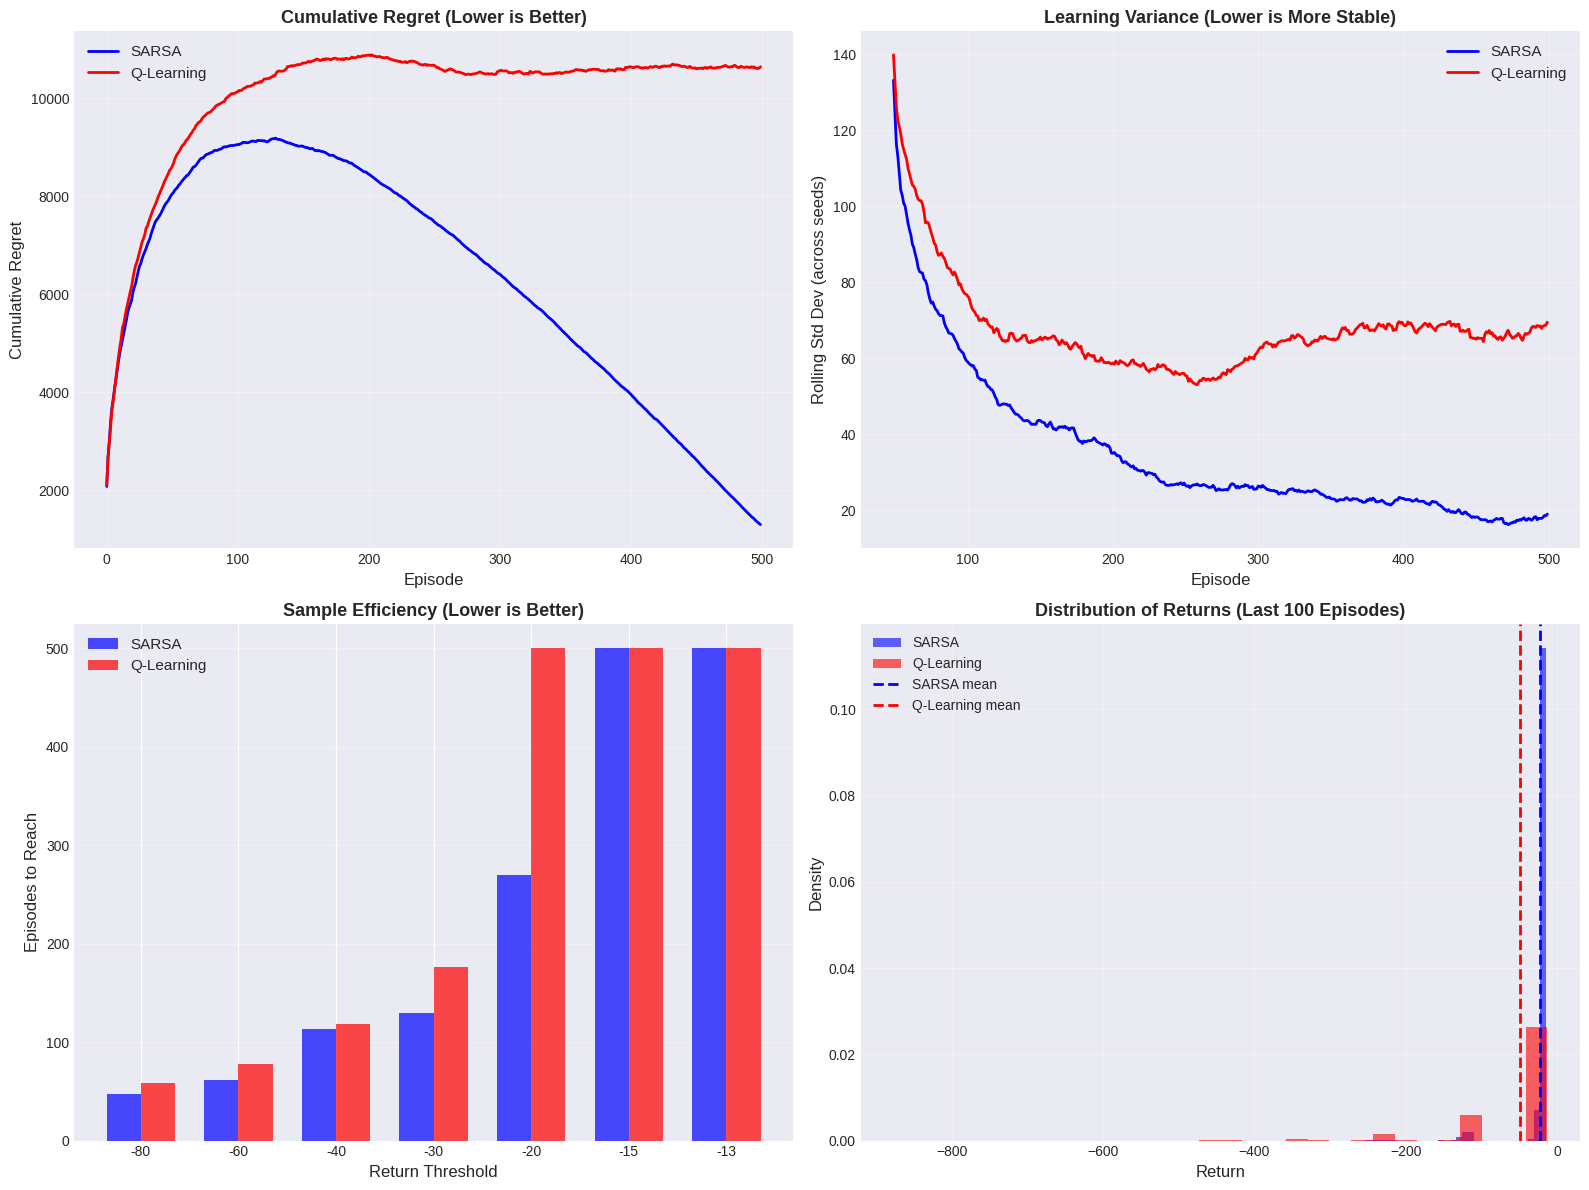

✓ Convergence analysis complete and saved


In [20]:
def plot_convergence_analysis(sarsa_results: Dict, qlearning_results: Dict):
    """
    Detailed convergence analysis comparing SARSA and Q-Learning.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    episodes = np.arange(len(sarsa_results['mean_returns']))

    # Plot 1: Cumulative regret
    ax = axes[0, 0]

    # Approximate optimal return (Q-learning's final performance)
    optimal_return = qlearning_results['final_mean']

    sarsa_regret = np.cumsum(optimal_return - sarsa_results['mean_returns'])
    qlearning_regret = np.cumsum(optimal_return - qlearning_results['mean_returns'])

    ax.plot(episodes, sarsa_regret, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes, qlearning_regret, label='Q-Learning', linewidth=2, color='red')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Regret', fontsize=12)
    ax.set_title('Cumulative Regret (Lower is Better)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 2: Variance over time
    ax = axes[0, 1]

    window = 50
    sarsa_rolling_std = pd.Series(sarsa_results['std_returns']).rolling(window).mean()
    qlearning_rolling_std = pd.Series(qlearning_results['std_returns']).rolling(window).mean()

    ax.plot(episodes, sarsa_rolling_std, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes, qlearning_rolling_std, label='Q-Learning', linewidth=2, color='red')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Rolling Std Dev (across seeds)', fontsize=12)
    ax.set_title('Learning Variance (Lower is More Stable)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 3: Sample efficiency (time to threshold)
    ax = axes[1, 0]

    thresholds = [-80, -60, -40, -30, -20, -15, -13]
    sarsa_times = []
    qlearning_times = []

    for threshold in thresholds:
        sarsa_time = np.argmax(sarsa_results['mean_returns'] > threshold)
        qlearning_time = np.argmax(qlearning_results['mean_returns'] > threshold)

        sarsa_times.append(sarsa_time if sarsa_time > 0 else 500)
        qlearning_times.append(qlearning_time if qlearning_time > 0 else 500)

    x = np.arange(len(thresholds))
    width = 0.35

    ax.bar(x - width/2, sarsa_times, width, label='SARSA', color='blue', alpha=0.7)
    ax.bar(x + width/2, qlearning_times, width, label='Q-Learning', color='red', alpha=0.7)

    ax.set_xlabel('Return Threshold', fontsize=12)
    ax.set_ylabel('Episodes to Reach', fontsize=12)
    ax.set_title('Sample Efficiency (Lower is Better)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(thresholds)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 4: Distribution of final returns
    ax = axes[1, 1]

    sarsa_final_returns = sarsa_results['all_returns'][:, -100:].flatten()
    qlearning_final_returns = qlearning_results['all_returns'][:, -100:].flatten()

    ax.hist(sarsa_final_returns, bins=30, alpha=0.6, label='SARSA', color='blue', density=True)
    ax.hist(qlearning_final_returns, bins=30, alpha=0.6, label='Q-Learning', color='red', density=True)

    ax.axvline(np.mean(sarsa_final_returns), color='blue', linestyle='--', linewidth=2, label='SARSA mean')
    ax.axvline(np.mean(qlearning_final_returns), color='red', linestyle='--', linewidth=2, label='Q-Learning mean')

    ax.set_xlabel('Return', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Distribution of Returns (Last 100 Episodes)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Convergence analysis complete and saved")


plot_convergence_analysis(sarsa_results, qlearning_results)


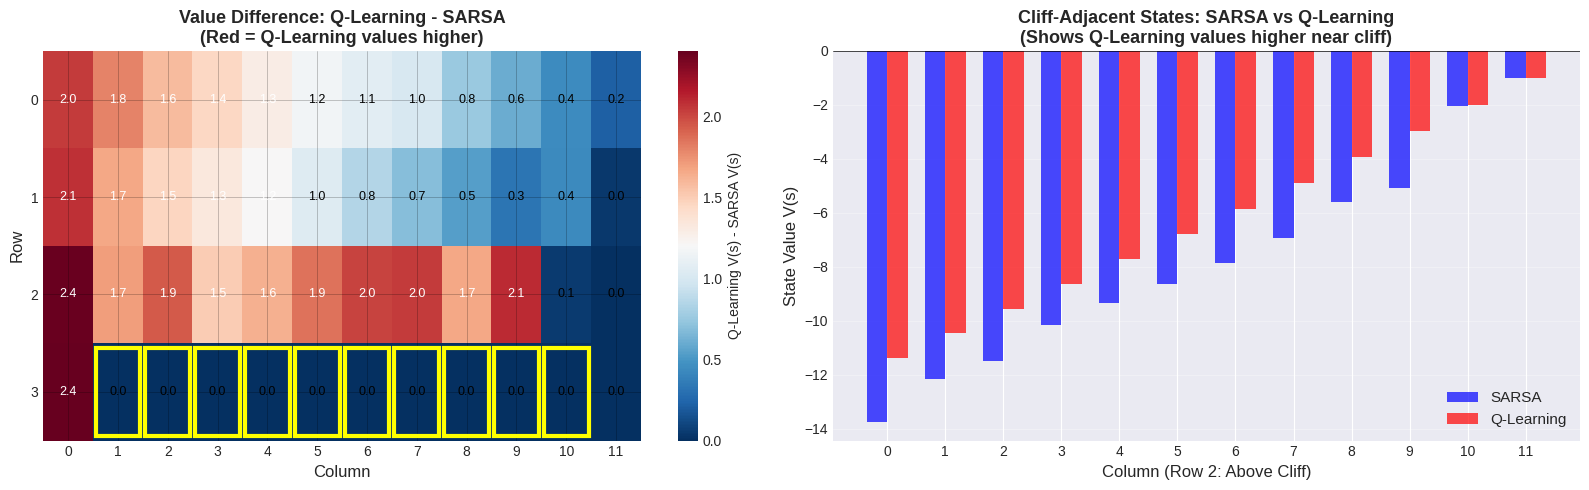


Q-VALUE DIFFERENCE ANALYSIS:
------------------------------------------------------------
Average difference (Q-Learning - SARSA): 0.97
Max difference: 2.40 at state 36
Min difference: 0.00 at state 35

States where Q-Learning has significantly higher values:

✓ Q-value difference analysis complete


In [21]:
def plot_q_value_differences(sarsa_Q: np.ndarray, qlearning_Q: np.ndarray):
    """
    Visualize the difference in Q-values between SARSA and Q-Learning.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Compute state value differences
    sarsa_V = np.max(sarsa_Q, axis=1)
    qlearning_V = np.max(qlearning_Q, axis=1)

    diff = qlearning_V - sarsa_V
    diff_grid = diff.reshape(4, 12)

    # Plot 1: Absolute difference
    ax = axes[0]
    im = ax.imshow(diff_grid, cmap='RdBu_r', interpolation='nearest', aspect='auto')
    plt.colorbar(im, ax=ax, label='Q-Learning V(s) - SARSA V(s)')

    # Annotate
    for i in range(4):
        for j in range(12):
            color = 'white' if abs(diff_grid[i, j]) > np.max(abs(diff_grid))*0.5 else 'black'
            ax.text(j, i, f'{diff_grid[i, j]:.1f}',
                   ha="center", va="center", color=color, fontsize=9)

    # Mark cliff
    for j in range(1, 11):
        ax.add_patch(plt.Rectangle((j-0.45, 3-0.45), 0.9, 0.9,
                                   fill=False, edgecolor='yellow', linewidth=3))

    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title('Value Difference: Q-Learning - SARSA\n(Red = Q-Learning values higher)',
                fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(4))
    ax.grid(True, which='both', color='black', linewidth=0.5, alpha=0.3)

    # Plot 2: Focus on cliff-adjacent row
    ax = axes[1]

    cliff_adjacent_states = [24 + i for i in range(12)]  # Row 2
    cliff_row_states = [36 + i for i in range(12)]        # Row 3 (cliff + start/goal)

    x = np.arange(12)
    width = 0.35

    sarsa_cliff_adj = [sarsa_V[s] for s in cliff_adjacent_states]
    qlearning_cliff_adj = [qlearning_V[s] for s in cliff_adjacent_states]

    ax.bar(x - width/2, sarsa_cliff_adj, width, label='SARSA', color='blue', alpha=0.7)
    ax.bar(x + width/2, qlearning_cliff_adj, width, label='Q-Learning', color='red', alpha=0.7)

    ax.set_xlabel('Column (Row 2: Above Cliff)', fontsize=12)
    ax.set_ylabel('State Value V(s)', fontsize=12)
    ax.set_title('Cliff-Adjacent States: SARSA vs Q-Learning\n(Shows Q-Learning values higher near cliff)',
                fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.savefig('q_value_differences.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print analysis
    print("\nQ-VALUE DIFFERENCE ANALYSIS:")
    print("-" * 60)
    print(f"Average difference (Q-Learning - SARSA): {np.mean(diff):.2f}")
    print(f"Max difference: {np.max(diff):.2f} at state {np.argmax(diff)}")
    print(f"Min difference: {np.min(diff):.2f} at state {np.argmin(diff)}")
    print()
    print("States where Q-Learning has significantly higher values:")
    significant = np.where(diff > 5)[0]
    for s in significant[:5]:
        row, col = s // 12, s % 12
        print(f"  State {s} (row={row}, col={col}): diff = {diff[s]:.2f}")

    print("\n✓ Q-value difference analysis complete")


plot_q_value_differences(sarsa_Q, qlearning_Q)


Tracking TD errors during learning...


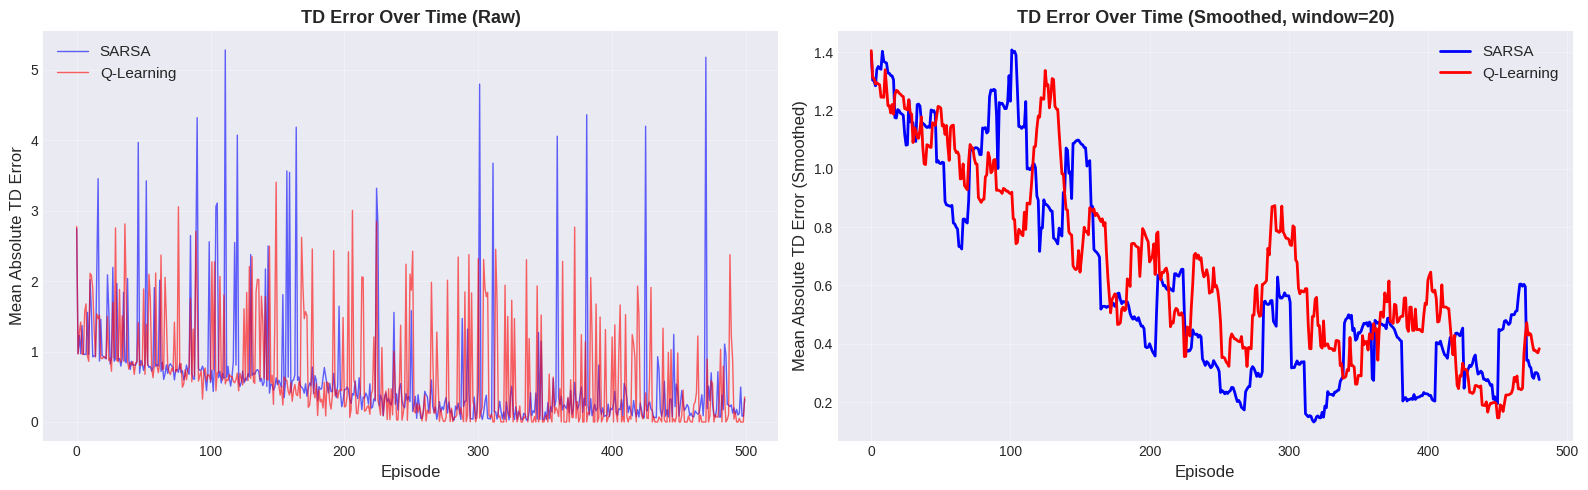


✓ TD error analysis complete
SARSA final TD error: 0.3526
Q-Learning final TD error: 0.2588


In [23]:
def analyze_td_errors_during_learning():
    """
    Track and analyze TD errors during learning for both algorithms.
    """
    print("\nTracking TD errors during learning...")

    env = gym.make("CliffWalking-v1")
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    num_episodes = 500
    alpha = 0.1
    gamma = 0.99
    epsilon = 0.1

    # Initialize
    sarsa_Q = np.zeros((n_states, n_actions))
    qlearning_Q = np.zeros((n_states, n_actions))

    sarsa_td_errors = []
    qlearning_td_errors = []

    # SARSA training with TD error tracking
    for episode in range(num_episodes):
        state, _ = env.reset(seed=episode)
        action = epsilon_greedy_action(sarsa_Q, state, epsilon, n_actions)

        episode_td_errors = []
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                next_action = epsilon_greedy_action(sarsa_Q, next_state, epsilon, n_actions)
                td_target = reward + gamma * sarsa_Q[next_state, next_action]
            else:
                td_target = reward
                next_action = None

            td_error = td_target - sarsa_Q[state, action]
            episode_td_errors.append(abs(td_error))
            sarsa_Q[state, action] += alpha * td_error

            state = next_state
            action = next_action

        sarsa_td_errors.append(np.mean(episode_td_errors))

    # Q-Learning training with TD error tracking
    for episode in range(num_episodes):
        state, _ = env.reset(seed=episode)

        episode_td_errors = []
        done = False

        while not done:
            action = epsilon_greedy_action(qlearning_Q, state, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                td_target = reward + gamma * np.max(qlearning_Q[next_state])
            else:
                td_target = reward

            td_error = td_target - qlearning_Q[state, action]
            episode_td_errors.append(abs(td_error))
            qlearning_Q[state, action] += alpha * td_error

            state = next_state

        qlearning_td_errors.append(np.mean(episode_td_errors))

    env.close()

    # Plot TD errors
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    episodes = np.arange(num_episodes)

    # Plot 1: Raw TD errors
    ax = axes[0]
    ax.plot(episodes, sarsa_td_errors, label='SARSA', alpha=0.6, linewidth=1, color='blue')
    ax.plot(episodes, qlearning_td_errors, label='Q-Learning', alpha=0.6, linewidth=1, color='red')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Mean Absolute TD Error', fontsize=12)
    ax.set_title('TD Error Over Time (Raw)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 2: Smoothed TD errors
    ax = axes[1]
    window = 20
    sarsa_smooth = np.convolve(sarsa_td_errors, np.ones(window)/window, mode='valid')
    qlearning_smooth = np.convolve(qlearning_td_errors, np.ones(window)/window, mode='valid')
    episodes_smooth = np.arange(len(sarsa_smooth))

    ax.plot(episodes_smooth, sarsa_smooth, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes_smooth, qlearning_smooth, label='Q-Learning', linewidth=2, color='red')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Mean Absolute TD Error (Smoothed)', fontsize=12)
    ax.set_title(f'TD Error Over Time (Smoothed, window={window})', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('td_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ TD error analysis complete")
    print(f"SARSA final TD error: {np.mean(sarsa_td_errors[-50:]):.4f}")
    print(f"Q-Learning final TD error: {np.mean(qlearning_td_errors[-50:]):.4f}")


analyze_td_errors_during_learning()

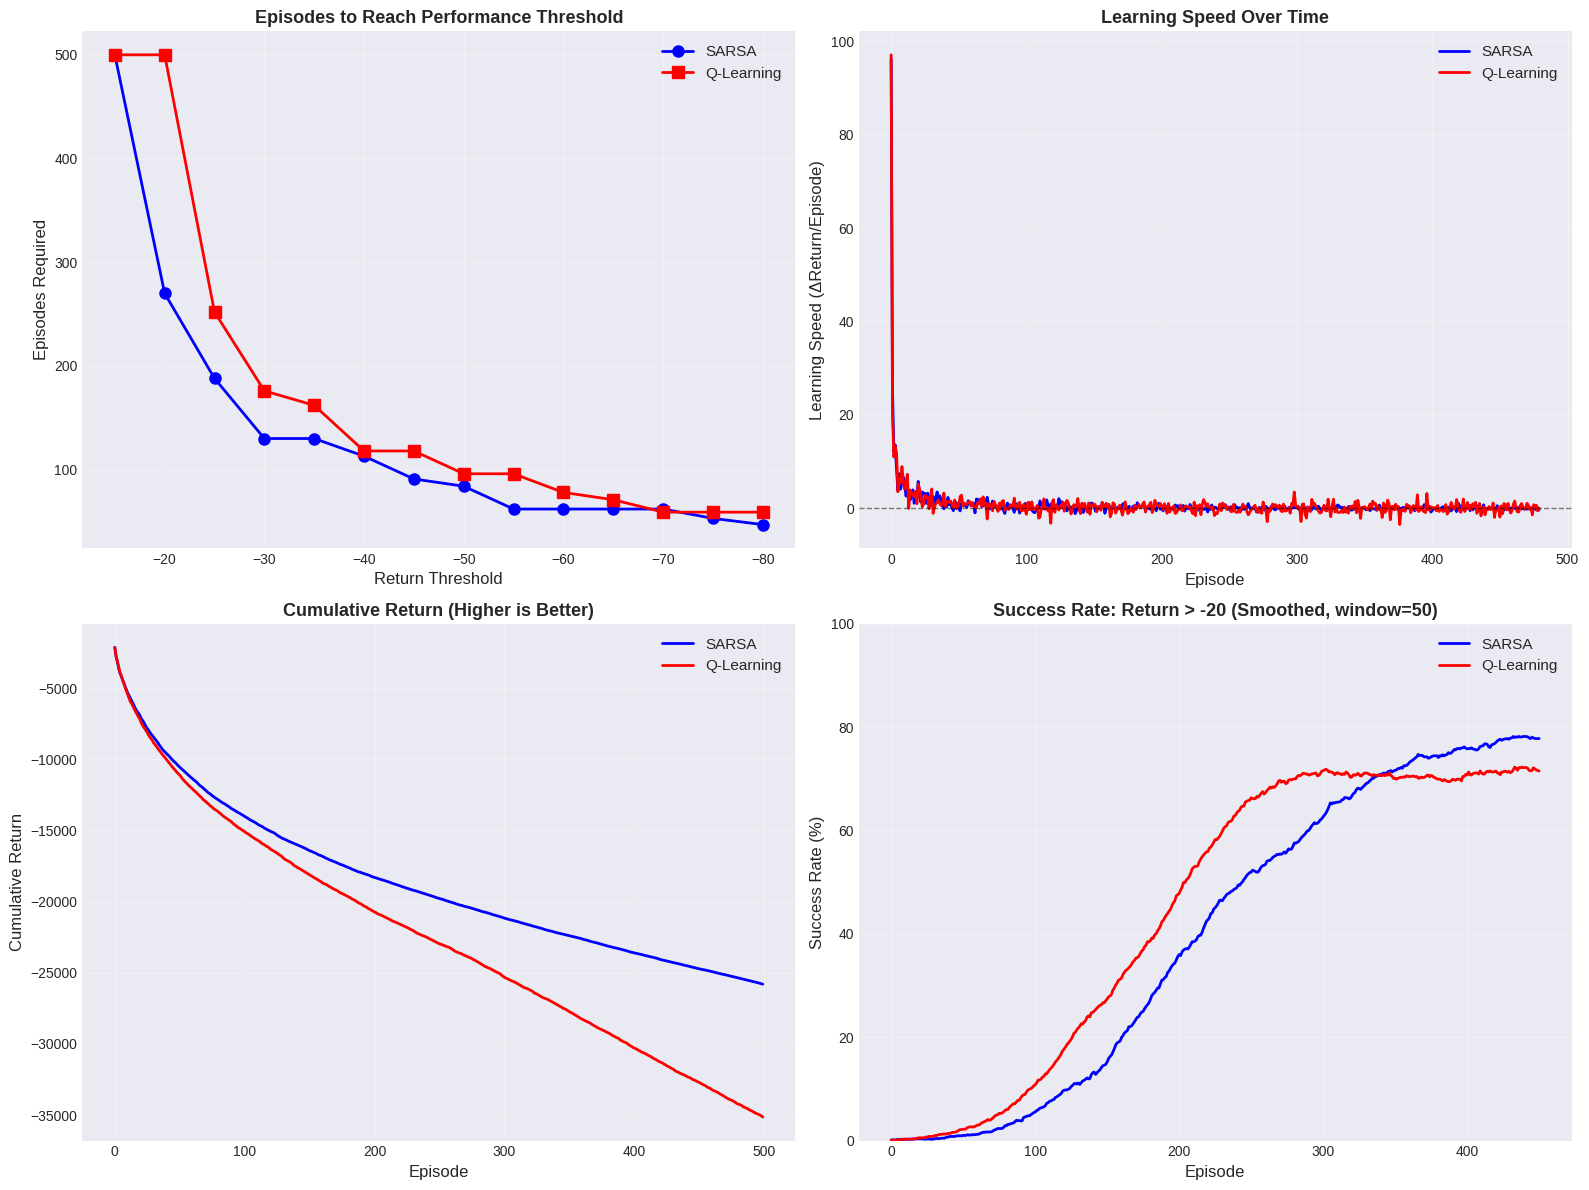


✓ Sample efficiency analysis complete

SAMPLE EFFICIENCY SUMMARY:
------------------------------------------------------------
Episodes to reach -20: SARSA=270, Q-Learning=500
Episodes to reach -15: SARSA=270, Q-Learning=500
Total cumulative return (500 eps):
  SARSA: -25798
  Q-Learning: -35140
  Difference: -9342


In [24]:
def sample_efficiency_analysis(sarsa_results: Dict, qlearning_results: Dict):
    """
    Detailed analysis of sample efficiency.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Episodes to reach performance thresholds
    ax = axes[0, 0]
    thresholds = np.arange(-80, -12, 5)
    sarsa_episodes = []
    qlearning_episodes = []

    for thresh in thresholds:
        sarsa_ep = np.argmax(sarsa_results['mean_returns'] >= thresh)
        qlearning_ep = np.argmax(qlearning_results['mean_returns'] >= thresh)
        sarsa_episodes.append(sarsa_ep if sarsa_ep > 0 else 500)
        qlearning_episodes.append(qlearning_ep if qlearning_ep > 0 else 500)

    ax.plot(thresholds, sarsa_episodes, marker='o', label='SARSA',
            linewidth=2, markersize=8, color='blue')
    ax.plot(thresholds, qlearning_episodes, marker='s', label='Q-Learning',
            linewidth=2, markersize=8, color='red')
    ax.set_xlabel('Return Threshold', fontsize=12)
    ax.set_ylabel('Episodes Required', fontsize=12)
    ax.set_title('Episodes to Reach Performance Threshold', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()

    # Plot 2: Learning speed (derivative of learning curve)
    ax = axes[0, 1]
    window = 20
    sarsa_speed = np.diff(sarsa_results['mean_returns'])
    qlearning_speed = np.diff(qlearning_results['mean_returns'])

    sarsa_speed_smooth = np.convolve(sarsa_speed, np.ones(window)/window, mode='valid')
    qlearning_speed_smooth = np.convolve(qlearning_speed, np.ones(window)/window, mode='valid')

    episodes = np.arange(len(sarsa_speed_smooth))
    ax.plot(episodes, sarsa_speed_smooth, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes, qlearning_speed_smooth, label='Q-Learning', linewidth=2, color='red')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Learning Speed (ΔReturn/Episode)', fontsize=12)
    ax.set_title('Learning Speed Over Time', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 3: Cumulative return
    ax = axes[1, 0]
    sarsa_cumulative = np.cumsum(sarsa_results['mean_returns'])
    qlearning_cumulative = np.cumsum(qlearning_results['mean_returns'])

    episodes = np.arange(len(sarsa_cumulative))
    ax.plot(episodes, sarsa_cumulative, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes, qlearning_cumulative, label='Q-Learning', linewidth=2, color='red')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.set_title('Cumulative Return (Higher is Better)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Plot 4: Success rate (episodes with return > -20)
    ax = axes[1, 1]
    window = 50

    sarsa_success = (sarsa_results['all_returns'] > -20).astype(float)
    qlearning_success = (qlearning_results['all_returns'] > -20).astype(float)

    sarsa_success_rate = np.mean(sarsa_success, axis=0)
    qlearning_success_rate = np.mean(qlearning_success, axis=0)

    sarsa_success_smooth = np.convolve(sarsa_success_rate, np.ones(window)/window, mode='valid')
    qlearning_success_smooth = np.convolve(qlearning_success_rate, np.ones(window)/window, mode='valid')

    episodes = np.arange(len(sarsa_success_smooth))
    ax.plot(episodes, sarsa_success_smooth * 100, label='SARSA', linewidth=2, color='blue')
    ax.plot(episodes, qlearning_success_smooth * 100, label='Q-Learning', linewidth=2, color='red')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Success Rate (%)', fontsize=12)
    ax.set_title(f'Success Rate: Return > -20 (Smoothed, window={window})',
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 100])

    plt.tight_layout()
    plt.savefig('sample_efficiency_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Sample efficiency analysis complete")

    # Print summary statistics
    print("\nSAMPLE EFFICIENCY SUMMARY:")
    print("-" * 60)
    print(f"Episodes to reach -20: SARSA={sarsa_episodes[12]}, Q-Learning={qlearning_episodes[12]}")
    print(f"Episodes to reach -15: SARSA={sarsa_episodes[-2]}, Q-Learning={qlearning_episodes[-2]}")
    print(f"Total cumulative return (500 eps):")
    print(f"  SARSA: {sarsa_cumulative[-1]:.0f}")
    print(f"  Q-Learning: {qlearning_cumulative[-1]:.0f}")
    print(f"  Difference: {qlearning_cumulative[-1] - sarsa_cumulative[-1]:.0f}")


sample_efficiency_analysis(sarsa_results, qlearning_results)